In [10]:
# Ensure CUDA and cuDNN are installed
!nvcc --version
!nvidia-smi

# Install the required dependencies for building TensorFlow with TensorRT support
!sudo apt-get update
!sudo apt-get install -y libnvinfer8 libnvinfer-dev libnvinfer-plugin8
# (Install other necessary packages as mentioned in TensorFlow documentation)

# Clone the TensorFlow repository and checkout the desired branch
!git clone https://github.com/tensorflow/tensorflow.git
%cd tensorflow
!git checkout r2.10 # Check the TensorFlow-TensorRT compatibility matrix for the correct branch.

# Configure TensorFlow build with TensorRT enabled
# ./configure
# (During configuration, enable TensorRT support when prompted)
# If you are using a virtual environment, activate it before building TensorFlow.

# Build and install TensorFlow
!bazel build --config=cuda --config=monolithic ... (Specify the build target with TensorRT support)
!bazel install ... (Install the built TensorFlow package)

# After successful installation, restart the runtime to ensure the new TensorFlow installation is used.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Tue Jan 21 09:24:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  7

In [1]:
!nvidia-smi

Tue Jan 21 09:35:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import numpy as np
import time

# Define ResNet9 architecture
def resnet9(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Block
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Conv Block 2
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Block 1
    residual1 = x
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, residual1])

    # Conv Block 3
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Conv Block 4
    x = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Block 2
    residual2 = x
    x = layers.Conv2D(512, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, residual2])

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define data augmentation
def get_data_augmentation():
    return models.Sequential([
        layers.RandomCrop(32, 32),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ])

# Hyperparameters
batch_size = 128
num_epochs = 50
learning_rate = 0.001
input_shape = x_train.shape[1:]
num_classes = 10

# Compile and Train Function
def compile_and_train(model, train_dataset, test_dataset, optimizer, epochs, report_metrics=True):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)
    if report_metrics:
        evaluate_metrics(model, test_dataset)
    return model, history

# Evaluate Metrics Function
def evaluate_metrics(model, test_dataset):
    y_true = []
    y_pred = []
    for x_batch, y_batch in test_dataset:
        predictions = model.predict(x_batch)
        y_true.extend(tf.argmax(y_batch, axis=1).numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}")
    return f1

# Latency Measurement Function
def measure_latency(model, input_shape):
    sample = tf.random.uniform((1, *input_shape))
    start_time = time.time()
    _ = model(sample)
    latency = time.time() - start_time
    print(f"Latency per sample: {latency * 1000:.4f} ms")
    return latency

# Training with data augmentation
data_augmentation = get_data_augmentation()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(50000).batch(batch_size).map(
    lambda x, y: (data_augmentation(x), y)
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Initialize and train the model
model = resnet9(input_shape, num_classes)
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Train and report metrics
model, history = compile_and_train(model, train_dataset, test_dataset, optimizer, num_epochs)

# Measure Latency
measure_latency(model, input_shape)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 165ms/step - accuracy: 0.3677 - loss: 1.9404 - val_accuracy: 0.3228 - val_loss: 2.0146
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 132ms/step - accuracy: 0.5632 - loss: 1.2119 - val_accuracy: 0.4529 - val_loss: 2.1131
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.6357 - loss: 1.0220 - val_accuracy: 0.5092 - val_loss: 1.6097
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.6773 - loss: 0.9100 - val_accuracy: 0.5626 - val_loss: 1.4177
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.7059 - loss: 0.8284 - val_accuracy: 0.6838 - val_loss: 0.9714
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.7450 - loss: 0.7392 - val_accuracy: 0.6193 - val_loss: 1.2393
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.7666 - loss: 0.6765 - val_accuracy: 0.7334 - val_loss: 0.7911
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.7805 - loss: 0.6298 - val

0.5938527584075928

In [11]:
# Test Function: Evaluate the model on test data
def test_model(model, test_dataset):
    print("Evaluating model...")
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy (Overall): {test_accuracy * 100:.2f}%")

    # Calculate F1 Score
    y_true = []
    y_pred = []
    for x_batch, y_batch in test_dataset:
        predictions = model.predict(x_batch)
        y_true.extend(tf.argmax(y_batch, axis=1).numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # Calculate and print class-wise accuracy
    class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    correct_per_class = [0] * 10
    total_per_class = [0] * 10

    for i in range(len(y_true)):
        true_class = y_true[i]
        predicted_class = y_pred[i]
        total_per_class[true_class] += 1
        if true_class == predicted_class:
            correct_per_class[true_class] += 1

    for i in range(10):
        class_accuracy = (correct_per_class[i] / total_per_class[i]) * 100 if total_per_class[i] > 0 else 0
        print(f"Test Accuracy of {class_names[i]}: {class_accuracy:.2f}% ({correct_per_class[i]}/{total_per_class[i]})")

    return test_loss, test_accuracy, f1


# Prediction Function: Make predictions on a single sample or batch
def predict_sample(model, sample):
    sample = np.expand_dims(sample, axis=0)  # Add batch dimension
    prediction = model.predict(sample)
    predicted_class = np.argmax(prediction, axis=1)
    print(f"Predicted class: {predicted_class[0]}")  # Class label
    return predicted_class


In [5]:
test_model(model, test_dataset)

Evaluating model...
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8607 - loss: 0.5781
Test Loss: 0.5589, Test Accuracy (Overall): 86.33%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━

(0.5589232444763184, 0.8633000254631042, 0.8624638903549582)

In [5]:
# Predicting on a single sample
sample_image = x_test[0]  # Select a random sample from the test set
predict_sample(model, sample_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Predicted class: 3


array([3])

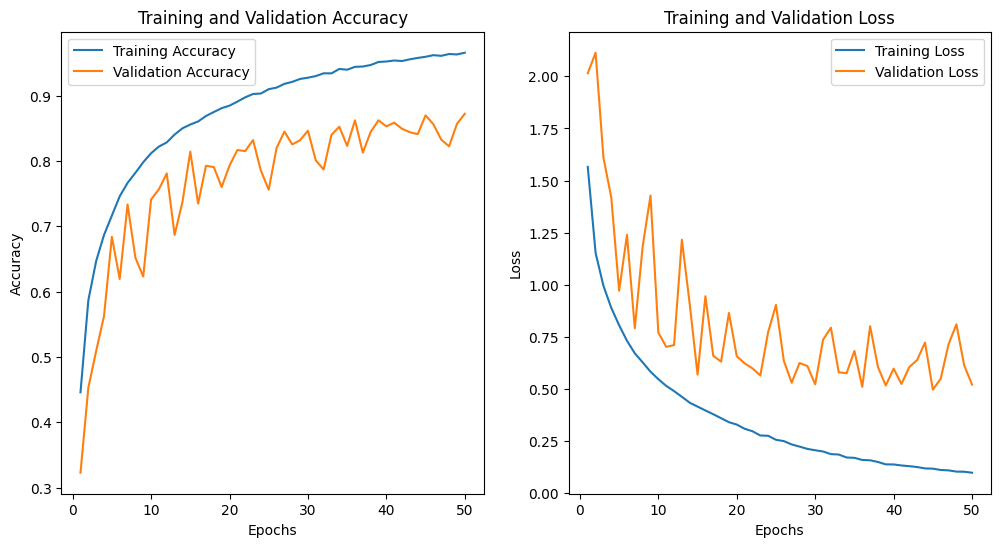

In [6]:
# Plot training metrics
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


# Plot Metrics
plot_training_metrics(history)


In [7]:
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt

# Save the model
saved_model = '/content/drive/MyDrive/cifar10_model'
model.export(saved_model)

model.save('/content/drive/MyDrive/cifar10_model_2.keras')
model.save('/content/drive/MyDrive/cifar_resnet_model_2.h5')


Saved artifact at '/content/drive/MyDrive/cifar10_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136162995530128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995530896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995530512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995531088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995530704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995532816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995531472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995533776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136162995533392: TensorSpec(shape=(), dtype=tf.resource, name=N

In [8]:
# Define TensorRT conversion
trt_model_dir = '/content/drive/MyDrive/trt_model'
converter = trt.TrtGraphConverterV2(input_saved_model_dir=saved_model)

# Convert to TensorRT
converter.convert()

# Save the converted model
converter.save(trt_model_dir)

print(f"TensorRT model saved to {trt_model_dir}")

TensorRT model saved to /content/drive/MyDrive/trt_model


In [9]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
import time

# Path to the saved TensorRT-optimized model
saved_model_dir = '/content/drive/MyDrive/trt_model'

# Load the TensorRT-optimized model
trt_model = tf.saved_model.load(saved_model_dir)
infer = trt_model.signatures["serving_default"]

# Convert the input data to float32 before inference
def evaluate_trt_model(infer, x_test, y_test):
    y_pred_classes = []

    # Convert y_test to class labels (not one-hot encoded)
    y_test_classes = np.argmax(y_test, axis=1)

    for img in x_test:
        # Perform inference with the correct data type
        predictions = infer(tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32))

        # Get the predicted class
        y_pred = tf.argmax(predictions['output_0'], axis=1).numpy()
        y_pred_classes.append(y_pred[0])

    # Calculate accuracy
    accuracy = np.mean(np.array(y_pred_classes) == y_test_classes)  # Compare class labels, not one-hot vectors

    # Generate classification report
    report = classification_report(y_test_classes, y_pred_classes, target_names=[str(i) for i in range(10)])

    return accuracy, report

# Evaluate the model after converting inputs to float32
accuracy, report = evaluate_trt_model(infer, x_test, y_test)

# Print results
print(f"TensorRT Model Accuracy: {accuracy * 100:.2f}%")
print(f"Classification Report:\n{report}")


TensorRT Model Accuracy: 87.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1000
           1       0.92      0.95      0.94      1000
           2       0.93      0.74      0.83      1000
           3       0.81      0.75      0.78      1000
           4       0.82      0.90      0.86      1000
           5       0.81      0.83      0.82      1000
           6       0.83      0.97      0.89      1000
           7       0.96      0.81      0.88      1000
           8       0.92      0.93      0.93      1000
           9       0.89      0.92      0.90      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [10]:
import time

def measure_latency(infer, inputs, batch_size=1):
    """
    Measures latency for single and batch inference.

    Parameters:
    - infer: TensorRT-optimized inference function
    - inputs: Input data for inference (e.g., test dataset)
    - batch_size: Number of images in a batch for batch inference

    Returns:
    - single_latency: Latency for a single inference (seconds)
    - batch_latency: Latency for batch inference (seconds)
    """
    # Single input
    single_input = tf.convert_to_tensor(np.expand_dims(inputs[0], axis=0), dtype=tf.float32)

    # Single inference latency
    start_time = time.time()
    infer(single_input)
    single_latency = time.time() - start_time

    # Batch input
    batch_input = tf.convert_to_tensor(inputs[:batch_size], dtype=tf.float32)

    # Batch inference latency
    start_time = time.time()
    infer(batch_input)
    batch_latency = time.time() - start_time

    return single_latency, batch_latency

batch_size = 64
single_latency, batch_latency = measure_latency(infer, x_test, batch_size=batch_size)

print(f"Single Inference Latency: {single_latency:.6f} seconds")
print(f"Batch Inference Latency (batch size={batch_size}): {batch_latency:.6f} seconds")


Single Inference Latency: 0.001873 seconds
Batch Inference Latency (batch size=64): 17.925333 seconds
